In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import gc
gc.collect

<function gc.collect(generation=2)>

In [5]:
dataset, dataset_info = tfds.load(name='rock_paper_scissors',                                                                                data_dir='tmp', with_info=True,as_supervised=True)  
dataset_train = dataset['train'] 
dataset_test = dataset['test'] 

In [8]:
train_size = dataset_info.splits['train'].num_examples  
test_size = dataset_info.splits['test'].num_examples  
dataset_classes = dataset_info.features['label'].num_classes  
print('dataset name:', dataset_info.name)  
print('train dataset:', dataset_train)  
print('test dataset:', dataset_test)  
print('train dataset size:', train_size)  
print('test dataset size:', test_size)  
print('number of classes in train and test dataset:', dataset_classes,
dataset_info.features['label'].names)  
print('shape of images in train and test dataset:', dataset_info.features['image'].shape)

dataset name: rock_paper_scissors
train dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
test dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
train dataset size: 2520
test dataset size: 372
number of classes in train and test dataset: 3 ['rock', 'paper', 'scissors']
shape of images in train and test dataset: (300, 300, 3)


2022-03-15 22:04:38.327784: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


15222

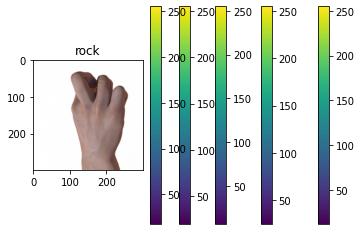

In [11]:
def plot_image(n=1):
  for image, label in dataset_train.take(n):  
        image = image.numpy()  
        label = label.numpy()  
        image_label = dataset_info.features['label'].int2str(label)  
        plt.imshow(image)  
        plt.title(image_label)  
        plt.colorbar()  

plot_image(5)  
gc.collect()

2022-03-15 22:05:31.933536: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


15219

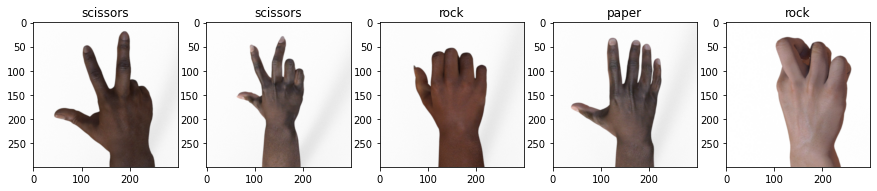

In [14]:
def plot_dataset(dataset, num=5):  
    plt.figure(figsize=(15, 15))  
    plot_index = 0  
    for image, label in dataset.take(num):  
        image = image.numpy()  
        label = label.numpy()  

        image_label = dataset_info.features['label'].int2str(label)  

        plot_index+=1  
        plt.subplot(3, 5, plot_index)  
        plt.title(image_label)  
        plt.imshow(image)  

plot_dataset(dataset_train, 5)
gc.collect()

2022-03-15 22:05:58.677995: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


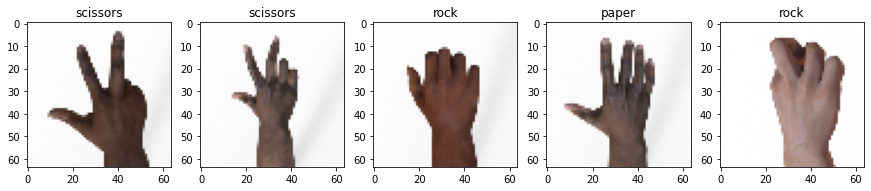

In [15]:
batch_size = 64  
image_size = 64  

def format_image(image, label):  
    image = tf.cast(image, tf.float32)  
    image = tf.image.resize(image, (image_size, image_size))  
    image /= 255  
    return image, label  

dataset_train = dataset_train.map(format_image)  
dataset_test = dataset_test.map(format_image)  

# Explore preprocessed training dataset images.
plot_dataset(dataset_train) 

In [16]:
def image_transpose(image):  
    rand = tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32)   
    image = tf.cond(rand < 0.5, lambda: tf.identity(image),lambda: tf.image.transpose(image))   
    return image  

def image_flip(image: tf.Tensor) -> tf.Tensor:  
    image = tf.image.random_flip_left_right(image)  
    image = tf.image.random_flip_up_down(image)  
    return image  

def image_rotate(image):  
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4,
 dtype=tf.int32))  
    rand = tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32)   
    def random_rotate(image):  
        image = tfa.image.rotate(image, tf.random.uniform(shape=[], minval=0 * np.pi / 180, maxval=360 * np.pi / 180,
 dtype=tf.float32))  
        return image  
    image = tf.cond(rand < 0.5,lambda: tf.identity(image),lambda: random_rotate(image))   
    return image    

def image_color(image: tf.Tensor) -> tf.Tensor:  
    image = tf.image.random_saturation(image, lower=0.5, upper=3)  
    image = tf.image.random_brightness(image, max_delta=0.2)  
    image = tf.image.random_contrast(image, lower=0.8, upper=1)  
    image = tf.image.random_hue(image, max_delta=0.03)  
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)  
    return image

def image_inversion(image: tf.Tensor) -> tf.Tensor:       
    rand = tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32)  
    image = tf.cond(rand < 0.8,lambda: tf.identity(image),lambda: tf.math.add(tf.math.multiply(image, -1), 1))   
    return image  

def image_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:       
    image_width, image_height, image_colors = image.shape  
    crop_size = (image_width, image_height)  

 # Generate crop settings, ranging from a 1% to 20% crop.     
    scales = list(np.arange(min_zoom, max_zoom, 0.01))  
    boxes = np.zeros((len(scales), 4))  

    for i, scale in enumerate(scales):           
        x1 = y1 = 0.5 - (0.5 * scale)  
        x2 = y2 = 0.5 + (0.5 * scale)  
        boxes[i] = [x1, y1, x2, y2]  

    def random_crop(img):   # Create different crops for an image         
        crops = tf.image.crop_and_resize(  
            [img], boxes=boxes, box_indices=np.zeros(len(scales)),               
            crop_size=crop_size  
        )  
 # Return a random crop
        return crops[tf.random.uniform(shape=[],minval=0, maxval=len(scales), dtype=tf.int32)]  
    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)  

 # Only apply cropping 50% of the time 
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))

2022-03-15 22:11:30.394948: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


20

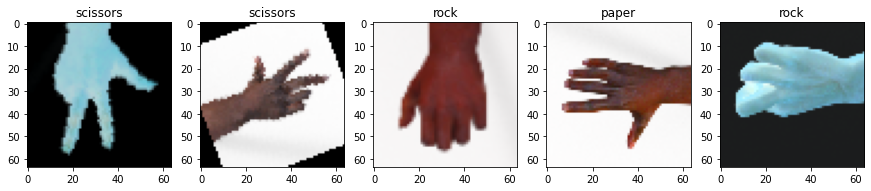

In [17]:
def augment_data(image, label):  
    image = image_flip(image)  
    image = image_color(image)  
    image = image_zoom(image)  
    image = image_transpose(image)  
    image = image_inversion(image)  
    image = image_rotate(image)  
    return image, label  

dataset_train_augmented = dataset_train.map(augment_data)  

plot_dataset(dataset_train_augmented)  
gc.collect()

In [18]:
dataset_train_batches = dataset_train_augmented.shuffle(buffer_size=train_size).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)   
dataset_test_batches = dataset_test.batch(batch_size)  
print(dataset_train_batches)   
print(dataset_test_batches) 

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [20]:
model = tf.keras.Sequential([tf.keras.layers.Convolution2D(input_shape=(image_size, image_size, 3), filters=64, kernel_size=3, activation='relu'), 
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Convolution2D(input_shape=(image_size, image_size, 3), filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),  
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Convolution2D(input_shape=(image_size, image_size, 3), filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),  
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Convolution2D(input_shape=(image_size, image_size, 3), filters=128, kernel_size=3, activation='relu'),  
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),  
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu),  
    tf.keras.layers.Dense(units=dataset_classes, activation=tf.keras.activations.softmax)  
]) 

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                        

In [23]:
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)  

model.compile(optimizer=rmsprop_optimizer,  
              loss='sparse_categorical_crossentropy',metrics=['accuracy'])  
steps_per_epoch = train_size // batch_size  
validation_steps = test_size // batch_size  

print('steps_per_epoch:', steps_per_epoch)  
print('validation_steps:', validation_steps)  
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy')

steps_per_epoch: 39
validation_steps: 5


In [24]:
training_history = model.fit(x=dataset_train_batches.repeat(),  
validation_data=dataset_test_batches.repeat(), 
                             epochs=15,   
                             steps_per_epoch=steps_per_epoch,  
                             validation_steps=validation_steps,  
                             callbacks=[early_stopping],  
                             verbose=1) 

Epoch 1/15


2022-03-15 22:14:40.514310: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62980096 exceeds 10% of free system memory.
2022-03-15 22:14:40.575334: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62980096 exceeds 10% of free system memory.
2022-03-15 22:14:40.608861: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 15745024 exceeds 10% of free system memory.
2022-03-15 22:14:40.623919: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62980096 exceeds 10% of free system memory.
2022-03-15 22:14:40.643509: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62980096 exceeds 10% of free system memory.


39/39 [==============================] - 56s 1s/step - loss: 1.2557 - accuracy: 0.3409 - val_loss: 1.0987 - val_accuracy: 0.3187
Epoch 2/15
39/39 [==============================] - 56s 1s/step - loss: 1.1600 - accuracy: 0.3555 - val_loss: 1.0973 - val_accuracy: 0.3500
Epoch 3/15
39/39 [==============================] - 57s 1s/step - loss: 1.0527 - accuracy: 0.4581 - val_loss: 1.0814 - val_accuracy: 0.5469
Epoch 4/15
39/39 [==============================] - 56s 1s/step - loss: 0.9224 - accuracy: 0.5827 - val_loss: 0.8696 - val_accuracy: 0.5844
Epoch 5/15
39/39 [==============================] - 55s 1s/step - loss: 0.7214 - accuracy: 0.7089 - val_loss: 0.6609 - val_accuracy: 0.7000
Epoch 6/15
39/39 [==============================] - 55s 1s/step - loss: 0.5391 - accuracy: 0.7748 - val_loss: 0.9358 - val_accuracy: 0.6406
Epoch 7/15
39/39 [==============================] - 54s 1s/step - loss: 0.4616 - accuracy: 0.8172 - val_loss: 0.5353 - val_accuracy: 0.7531
Epoch 8/15
39/39 [=============

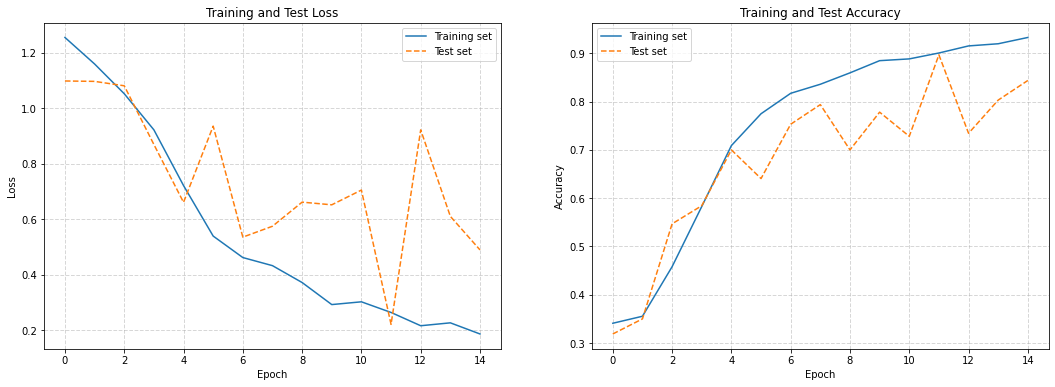

21181

In [26]:
def plot_training_history(training_history):  
    loss = training_history.history['loss']     
    val_loss = training_history.history['val_loss']
    accuracy = training_history.history['accuracy']     
    val_accuracy = training_history.history['val_accuracy']
    plt.figure(figsize=(18, 6))  

    plt.subplot(1, 2, 1)  
    plt.title('Training and Test Loss')  
    plt.xlabel('Epoch')  
    plt.ylabel('Loss')  
    plt.plot(loss, label='Training set')  
    plt.plot(val_loss, label='Test set', linestyle='--')  
    plt.legend()  
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)  
    plt.subplot(1, 2, 2)  
    plt.title('Training and Test Accuracy')  
    plt.xlabel('Epoch')  
    plt.ylabel('Accuracy')  
    plt.plot(accuracy, label='Training set')  
    plt.plot(val_accuracy, label='Test set', linestyle='--')  
    plt.legend()  
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)  
    plt.show()  

plot_training_history(training_history)  
gc.collect()  

In [27]:
train_loss, train_accuracy = model.evaluate(dataset_train.batch(batch_size).
take(train_size))  
test_loss, test_accuracy = model.evaluate(dataset_test.batch(batch_size).
take(test_size))  

print('Training Loss: ', train_loss)  
print('Training Accuracy: ', train_accuracy)  
print('Test Loss: ', test_loss)  
print('Test Accuracy: ', test_accuracy)


6/6 [==============================] - 2s 256ms/step - loss: 0.4600 - accuracy: 0.8522
Training Loss:  0.023836003616452217
Training Accuracy:  0.9936507940292358
Test Loss:  0.46003809571266174
Test Accuracy:  0.852150559425354


In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)  
tflite_model = converter.convert()  
with open('model.tflite', 'wb') as f:  
    f.write(tflite_model)  

converter = tf.lite.TFLiteConverter.from_keras_model(model)  
converter.optimizations = [tf.lite.Optimize.DEFAULT]  
tflite_quant_model = converter.convert()  
with open('quant_model.tflite', 'wb') as f:  
    f.write(tflite_quant_model) 

2022-03-15 22:30:30.286785: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmp6cl4bdip/assets


INFO:tensorflow:Assets written to: /tmp/tmp6cl4bdip/assets
2022-03-15 22:30:32.092111: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-03-15 22:30:32.092162: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-03-15 22:30:32.095902: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp6cl4bdip
2022-03-15 22:30:32.100079: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-03-15 22:30:32.100119: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmp6cl4bdip
2022-03-15 22:30:32.115160: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-03-15 22:30:32.199091: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmp6cl4bdip
2022-03-15 22:30:32.221837: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfores5ut/assets


INFO:tensorflow:Assets written to: /tmp/tmpfores5ut/assets
2022-03-15 22:30:34.801171: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-03-15 22:30:34.801216: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-03-15 22:30:34.801472: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpfores5ut
2022-03-15 22:30:34.804442: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-03-15 22:30:34.804468: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpfores5ut
2022-03-15 22:30:34.812026: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-03-15 22:30:34.881294: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpfores5ut
2022-03-15 22:30:34.900751: I tensorflow/cc/saved_model/loader.cc:301] SavedModel